In [1]:
print('Hellooo!')

Hellooo!


In [2]:
import time
from pyspark import SparkConf
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as F

In [3]:
BASE_DIR='/usr/local/google/home/bashir/git_repos/bashir2/openmrs-fhir-warehouse/tmp/temp_test_parquet/'
BASE_PATIENT_URL='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/'

In [4]:
conf = (SparkConf()
        .setMaster('local[20]')
        .setAppName('IndicatorsApp')
        .set('spark.executor.memory', '2g')
        # We don't explicitly `cache()` but it should happen automatically after shuffles; so
        # we need to be careful if we want to change the following (the defaults is 0.6).
        #
        # NOTE: It seems in some cases automatic caching after shuffle is not happening,
        # see examples/notes below.
        #
        #.set('spark.storage.memoryFraction', 0.2)
       )

In [5]:
conf

In [6]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Loading Parquet files, sample aggregate queries, and Pandas conversion.
The `Observation` directory below contained 441MB of Parquet content at the time of these tests.
These are generated from the test data in the docker test image repeated 64 times.

Note there are some inconsistencies in the number of resources which needs to be investigated in
the batch pipeline.

In [7]:
start = time.time()
#all_obs = spark.read.parquet(BASE_DIR + 'Observation/*-00005')
all_obs = spark.read.parquet(BASE_DIR + 'Observation')
end = time.time()
print('Elapsed time: ', end - start)

Elapsed time:  4.37597393989563


In [8]:
start = time.time()
print('Number of observations= ', all_obs.count())
end = time.time()
print('Elapsed time: ', end - start)

Number of observations=  2745600
Elapsed time:  5.8592164516448975


In [9]:
all_patients = spark.read.parquet(BASE_DIR + '/Patient')
print('Number of patients= ', all_patients.count())

Number of patients=  600


In [10]:
all_encounters = spark.read.parquet(BASE_DIR + '/Encounter')
print('Number of encounters= ', all_encounters.count())

Number of encounters=  6786


In [11]:
start_date='2020-12-09'
end_date='2020-12-10'

In [12]:
obs_filtered = all_obs.select(
      'subject.patientId', 'effective.dateTime', 'code', 'value').filter(
      all_obs.effective.dateTime > start_date).filter(
      all_obs.effective.dateTime < end_date)
print('Number of filtered observations= ', obs_filtered.count())

Number of filtered observations=  2560


In [13]:
obs_filtered.head()

Row(patientId='e41b559d-3555-4efd-8742-996576d75dee', dateTime='2020-12-09T08:29:49+00:00', code=Row(id=None, coding=[Row(id=None, system=None, version=None, code='5086AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Diastolic blood pressure', userSelected=None)], text=None), value=Row(quantity=Row(id=None, value=Decimal('62.0000'), comparator=None, unit=None, system=None, code=None), codeableConcept=None, string=None, boolean=None, range=None, ratio=None, sampledData=None, attachment=None, time=None, dateTime=None, period=None))

In [14]:
obs_codes = obs_filtered.select(
    obs_filtered.patientId, obs_filtered.dateTime, obs_filtered.value,
    F.explode(obs_filtered.code.coding).alias('coding'))
grouped_obs = obs_codes.groupBy(['coding.code']).agg({'*':'count'})
print('Number of codes= ', grouped_obs.count())
grouped_obs.head(5)

Number of codes=  13


[Row(code='5088AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', count(1)=192),
 Row(code='5086AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', count(1)=192),
 Row(code='162169AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', count(1)=256),
 Row(code='1284AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', count(1)=192),
 Row(code='5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', count(1)=256)]

In [15]:
# Repeating the same cell with `all_obs` to check performance difference.
all_obs_codes = all_obs.select(
    all_obs.subject.patientId, all_obs.effective.dateTime, all_obs.value,
    F.explode(all_obs.code.coding).alias('coding'))
#grouped_all_obs = all_obs_codes.groupBy(['coding.code']).agg(
#    {'*':'count'}).withColumnRenamed('count(1)', 'num_obs')
grouped_all_obs = all_obs_codes.groupBy([all_obs_codes.coding.code.alias('coding_code')]).agg(
    F.count('*').alias('num_obs'))
print('Number of codes= ', grouped_all_obs.count())
grouped_all_obs.head(5)

Number of codes=  13


[Row(coding_code='5088AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=182208),
 Row(coding_code='5086AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=182400),
 Row(coding_code='162169AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=180736),
 Row(coding_code='1284AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=273664),
 Row(coding_code='5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=184128)]

In [16]:
grouped_all_obs.show()

+--------------------+-------+
|         coding_code|num_obs|
+--------------------+-------+
|5088AAAAAAAAAAAAA...| 182208|
|5086AAAAAAAAAAAAA...| 182400|
|162169AAAAAAAAAAA...| 180736|
|1284AAAAAAAAAAAAA...| 273664|
|5089AAAAAAAAAAAAA...| 184128|
|5087AAAAAAAAAAAAA...| 182400|
|5085AAAAAAAAAAAAA...| 184128|
|5090AAAAAAAAAAAAA...| 183488|
|159394AAAAAAAAAAA...| 273856|
|5242AAAAAAAAAAAAA...| 184896|
|159947AAAAAAAAAAA...| 274944|
|5092AAAAAAAAAAAAA...| 183808|
|159946AAAAAAAAAAA...| 274944|
+--------------------+-------+



In [17]:
grouped_all_obs_P = grouped_all_obs.toPandas()
grouped_all_obs_P

,coding_code,num_obs
0,5088AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,182208
1,5086AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,182400
2,162169AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,180736
3,1284AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,273664
4,5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,184128
5,5087AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,182400
6,5085AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,184128
7,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,183488
8,159394AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,273856
9,5242AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,184896


In [18]:
# Verifying that all observations have a code.
grouped_all_obs_P['num_obs'].sum()

2745600

# Restructure Observations and join with Patients

In [19]:
all_obs.head()

Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Observation/fb2557a1-7473-4a9b-9bfd-b698dbef8258', meta=None, implicitRules=None, language=None, text=None, contained=None, identifier=None, basedOn=None, status='amended', category=[Row(id=None, coding=[Row(id=None, system='http://terminology.hl7.org/CodeSystem/observation-category', version=None, code='exam', display='Exam', userSelected=None)], text=None)], code=Row(id=None, coding=[Row(id=None, system=None, version=None, code='159946AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Diagnosis order', userSelected=None)], text=None), subject=Row(DeviceId=None, GroupId=None, LocationId=None, PatientId='1eaa25ac-28b2-49c4-bf83-df9533d65eb8', id=None, reference='Patient/1eaa25ac-28b2-49c4-bf83-df9533d65eb8', identifier=None, display='Joshua González (OpenMRS ID: 100E1E)'), context=Row(EncounterId='eed74c4c-0f7a-488b-9405-b4a86716434b', EpisodeOfCareId=None, id=None, reference='Encounter/eed74c4c-0f7a-488b-9405-b4a86716434b', identifier=None, dis

In [20]:
coded_obs = all_obs.select(
    all_obs.subject.patientId.alias('patientId'),
    all_obs.effective.dateTime.alias('dateTime'),
    all_obs.value,
    F.explode(all_obs.code.coding).alias('coding'))
coded_obs.head()

Row(patientId='1eaa25ac-28b2-49c4-bf83-df9533d65eb8', dateTime='2019-10-07T09:14:34+00:00', value=Row(quantity=None, codeableConcept=Row(id=None, coding=[Row(id=None, system=None, version=None, code='159944AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Secondary', userSelected=None)], text=None), string=None, boolean=None, range=None, ratio=None, sampledData=None, attachment=None, time=None, dateTime=None, period=None), coding=Row(id=None, system=None, version=None, code='159946AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Diagnosis order', userSelected=None))

In [21]:
all_patients.head()

Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/80d54136-d00b-4dc1-a716-22e99e9f65d1', meta=None, implicitRules=None, language=None, text=None, contained=None, identifier=[Row(id='73e2d312-a785-4f41-8ea7-2b90d9a00af7', use='official', type=Row(id=None, coding=None, text='OpenMRS ID'), system=None, value='1002GU', period=None, assigner=None)], active=True, name=[Row(id='1b8adda2-c370-4114-96c3-c9056afea3df', use=None, text=None, family='Johnson', given=['Betty'], prefix=None, suffix=None, period=None)], telecom=None, gender='female', birthDate='1998-02-20', deceased=Row(boolean=False, dateTime=None), address=[Row(id='f36ff160-a06f-4af5-8270-ded8e570e142', use='home', type=None, text=None, line=None, city='City5489', district=None, state='State5489', postalCode='85489', country='Country5489', period=None)], maritalStatus=None, multipleBirth=None, photo=None, contact=None, animal=None, communication=None, generalPractitioner=None, managingOrganization=None, link=None)

In [22]:
patient_name = all_patients.select(
    all_patients.id,
    all_patients.name[0].given[0].alias('given'),
    all_patients.name[0].family.alias('family')).withColumn(
      'core_id', F.regexp_replace('id', BASE_PATIENT_URL, ''))
patient_name.head()

Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/80d54136-d00b-4dc1-a716-22e99e9f65d1', given='Betty', family='Johnson', core_id='80d54136-d00b-4dc1-a716-22e99e9f65d1')

In [23]:
joined_obs = patient_name.join(
    coded_obs, patient_name.core_id == coded_obs.patientId)
print('Number of joined rows= ', joined_obs.count())
joined_obs.head()

Number of joined rows=  1689856


Row(id='http://localhost:8099/openmrs/ws/fhir2/R4/Patient/8ad40cda-d588-4d3a-bd8f-340ad91cd1dd', given='Jennifer', family='Anderson', core_id='8ad40cda-d588-4d3a-bd8f-340ad91cd1dd', patientId='8ad40cda-d588-4d3a-bd8f-340ad91cd1dd', dateTime='2020-02-06T08:25:01+00:00', value=Row(quantity=Row(id=None, value=Decimal('220.0000'), comparator=None, unit=None, system=None, code=None), codeableConcept=None, string=None, boolean=None, range=None, ratio=None, sampledData=None, attachment=None, time=None, dateTime=None, period=None), coding=Row(id=None, system=None, version=None, code='5087AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', display='Pulse', userSelected=None))

In [24]:
print('all_obs: {} coded_obs: {}'.format(all_obs.count(), coded_obs.count()))

all_obs: 2745600 coded_obs: 2745600


In [25]:
agg_obs = joined_obs.groupBy(
    [joined_obs.patientId, joined_obs.given, joined_obs.family, joined_obs.coding.code]).agg(
    {'*':'count', 'value.quantity.value':'max'}).withColumnRenamed('count(1)', 'num_obs')
agg_obs.head(5)

[Row(patientId='e7a0cf31-54fa-49fa-a5d9-2581493618d1', given='Nancy', family='Harris', coding[code]='5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', max(value.quantity.value AS `value`)=Decimal('181.0000'), num_obs=384),
 Row(patientId='0ade630a-f6f2-43e5-9020-8be3a4f26068', given='George', family='Young', coding[code]='5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', max(value.quantity.value AS `value`)=Decimal('12.0000'), num_obs=64),
 Row(patientId='37880e58-a527-4472-980c-74d7e669486c', given='John', family='Lewis', coding[code]='159394AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', max(value.quantity.value AS `value`)=None, num_obs=384),
 Row(patientId='58aa1147-09fc-43dd-a83d-387d17bd6bce', given='Edward', family='Taylor', coding[code]='159394AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', max(value.quantity.value AS `value`)=None, num_obs=512),
 Row(patientId='0165cf25-8438-4d9c-b575-cd3913c66fbf', given='Michael', family='Lee', coding[code]='162169AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', max(value.quantity.value AS `value`)=None, num

In [26]:
agg_obs = joined_obs.groupBy([
    joined_obs.patientId,
    joined_obs.given,
    joined_obs.family,
    joined_obs.coding.code.alias('coding_code')
]).agg(
    F.count('*').alias('num_obs'),
    F.max(joined_obs.value.quantity.value).alias('max_value'),
    F.min(joined_obs.dateTime).alias('min_date'),
    F.max(joined_obs.dateTime).alias('max_date')
)
print('Number of aggregated rows= ', agg_obs.count())
#agg_obs.head(5)

Number of aggregated rows=  6617


In [27]:
# With no filter this can cause out-of-memory issues, probably because of the shuffle size or
# issues around partitioning which we have not experimented with yet.

agg_obs.filter(agg_obs.patientId == 'e7a0cf31-54fa-49fa-a5d9-2581493618d1').head(5)

[Row(patientId='e7a0cf31-54fa-49fa-a5d9-2581493618d1', given='Nancy', family='Harris', coding_code='5088AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=256, max_value=Decimal('38.0000'), min_date='2019-05-22T08:28:38+00:00', max_date='2019-08-28T07:58:39+00:00'),
 Row(patientId='e7a0cf31-54fa-49fa-a5d9-2581493618d1', given='Nancy', family='Harris', coding_code='5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=384, max_value=Decimal('181.0000'), min_date='2019-01-14T08:28:39+00:00', max_date='2020-08-17T08:15:38+00:00'),
 Row(patientId='e7a0cf31-54fa-49fa-a5d9-2581493618d1', given='Nancy', family='Harris', coding_code='159947AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=832, max_value=None, min_date='2019-01-14T09:13:39+00:00', max_date='2020-11-24T09:38:40+00:00'),
 Row(patientId='e7a0cf31-54fa-49fa-a5d9-2581493618d1', given='Nancy', family='Harris', coding_code='5089AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=512, max_value=Decimal('171.0000'), min_date='2019-01-14T08:28:39+00:00', max_date='2020-

# Making some functions out of these

In [43]:
def flatten_obs(obs: DataFrame) -> DataFrame:
  return obs.select(
      obs.subject.patientId.alias('patientId'),
      obs.effective.dateTime.alias('dateTime'),
      obs.value,
      F.explode(obs.code.coding).alias('coding'))

def aggregate_code_per_patient(
    flat_obs: DataFrame, code: str, start_date: str=None, end_date: str=None) -> DataFrame:
  if code is None:
    raise ValueError('`code` is expected to be a valid code string.')
  start_obs = flat_obs
  if start_date:
    start_obs = flat_obs.filter(flat_obs.dateTime > start_date)
  date_obs = start_obs
  if end_date:
    date_obs = start_obs.filter(start_obs.dateTime < end_date)
  code_obs = date_obs.filter(date_obs.coding.code == code)
  return code_obs.groupBy([
    flat_obs.patientId,
    flat_obs.coding.code.alias('coding_code')
  ]).agg(
    F.count('*').alias('num_obs'),
    F.min(flat_obs.value.quantity.value).alias('min_value'),
    F.max(flat_obs.value.quantity.value).alias('max_value'),
    F.min(flat_obs.dateTime).alias('min_date'),
    F.max(flat_obs.dateTime).alias('max_date')
  )

In [44]:
flat_obs = flatten_obs(all_obs)
flat_obs.count()

2745600

In [45]:
aggregated_code_obs = aggregate_code_per_patient(flat_obs, '5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
aggregated_code_obs.cache()
aggregated_code_obs.count()

844

In [46]:
# Note without the above `cache()` this will take another 7-8 seconds.
aggregated_code_obs.head(5)

[Row(patientId='0a35552c-f4f7-4930-81a4-60d85ffcd6ba', coding_code='5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=128, min_value=Decimal('106.0000'), max_value=Decimal('140.0000'), min_date='2019-05-30T08:20:20+00:00', max_date='2020-10-29T08:22:19+00:00'),
 Row(patientId='cc32422b-2f23-4ead-8612-b3dca499929d', coding_code='5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=448, min_value=Decimal('31.0000'), max_value=Decimal('154.0000'), min_date='2019-03-20T08:21:29+00:00', max_date='2020-06-09T08:07:29+00:00'),
 Row(patientId='f16b5191-af47-4c5a-b9ca-71e0a4365824', coding_code='5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=320, min_value=Decimal('56.0000'), max_value=Decimal('173.0000'), min_date='2019-06-12T08:35:27+00:00', max_date='2020-08-18T08:09:27+00:00'),
 Row(patientId='124d1b17-d3f8-4366-91d5-f66eef64f030', coding_code='5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA', num_obs=192, min_value=Decimal('42.0000'), max_value=Decimal('202.0000'), min_date='2020-04-29T08:42:05+00:00', max_da

In [47]:
aggregated_code_obs_P = aggregated_code_obs.toPandas()
aggregated_code_obs_P.head()

,patientId,coding_code,num_obs,min_value,max_value,min_date,max_date
0,0a35552c-f4f7-4930-81a4-60d85ffcd6ba,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,128,106.0,140.0,2019-05-30T08:20:20+00:00,2020-10-29T08:22:19+00:00
1,cc32422b-2f23-4ead-8612-b3dca499929d,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,448,31.0,154.0,2019-03-20T08:21:29+00:00,2020-06-09T08:07:29+00:00
2,f16b5191-af47-4c5a-b9ca-71e0a4365824,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,320,56.0,173.0,2019-06-12T08:35:27+00:00,2020-08-18T08:09:27+00:00
3,124d1b17-d3f8-4366-91d5-f66eef64f030,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,192,42.0,202.0,2020-04-29T08:42:05+00:00,2020-09-24T08:52:06+00:00
4,393d07ea-a310-40fc-9f29-d5b91e1b2675,5090AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,64,29.0,29.0,2019-11-22T08:54:40+00:00,2019-11-22T08:54:40+00:00


<AxesSubplot:xlabel='min_value', ylabel='max_value'>

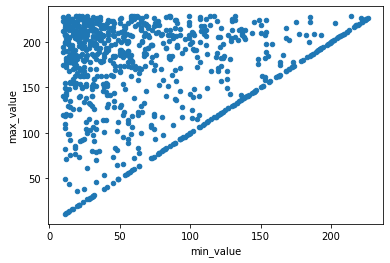

In [50]:
# This is just to showcase conversion to Pandas and graph functionality; the
# data has no realistic meaning as they are randomly generated.
aggregated_code_obs_P.plot(kind='scatter', x='min_value', y='max_value')